# Lets import some things

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as transforms
import time
from torchsummary import summary
import scipy.io

In [2]:
mat = scipy.io.loadmat('data/flowers-102/imagelabels.mat')
print(len(mat['labels'][0])) #it turns out the image labels are numbers and i cant recognise flowers by eye. nvm i found someone helpful online

8189


# I found a text file with the classnames

In [3]:
names = [ 'pink primrose','hard-leaved pocket orchid','canterbury bells','sweet pea','english marigold','tiger lily','moon orchid','bird of paradise','monkshood','globe thistle','snapdragon',"colt's foot",'king protea','spear thistle','yellow iris','globe-flower','purple coneflower','peruvian lily','balloon flower','giant white arum lily','fire lily','pincushion flower','fritillary','red ginger','grape hyacinth','corn poppy','prince of wales feathers','stemless gentian','artichoke','sweet william','carnation','garden phlox','love in the mist','mexican aster','alpine sea holly','ruby-lipped cattleya','cape flower','great masterwort','siam tulip','lenten rose','barbeton daisy','daffodil','sword lily','poinsettia','bolero deep blue','wallflower','marigold','buttercup','oxeye daisy','common dandelion','petunia','wild pansy','primula','sunflower','pelargonium','bishop of llandaff','gaura','geranium','orange dahlia','pink-yellow dahlia?','cautleya spicata','japanese anemone','black-eyed susan','silverbush','californian poppy','osteospermum','spring crocus','bearded iris','windflower','tree poppy','gazania','azalea','water lily','rose','thorn apple','morning glory','passion flower','lotus','toad lily','anthurium','frangipani','clematis','hibiscus','columbine','desert-rose','tree mallow','magnolia','cyclamen ','watercress','canna lily','hippeastrum ','bee balm','ball moss','foxglove','bougainvillea','camellia','mallow','mexican petunia','bromelia','blanket flower','trumpet creeper','blackberry lily']

# Decide if cuda

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

cuda


# Load dataset

In [5]:
trainingData = datasets.Flowers102(
    root="data",
    split = "train",
    download = True,
    transform = transforms.Compose([
        transforms.RandomResizedCrop((256, 256),antialias=True,scale=(0.85,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20), 
        transforms.ColorJitter(contrast=0.1,brightness=0.1, saturation=0.1,hue=0.05),#becaise the dataset will evidently be sensitve to colour might want to avoid this one
        transforms.RandomAffine(degrees=5,translate=(0.1,0.1),scale=(0.9,1.1),shear=0.15),
        # transforms.GaussianBlur(kernel_size=(3,3),sigma=(0.1,0.8)),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.432, 0.381, 0.296], [0.258,  0.209, 0.221] )
    ])
)
testData = datasets.Flowers102(
    root="data",
    split= "test",
    download = True,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.432, 0.381, 0.296], [0.258,  0.209, 0.221] )
    ])
)
valData = datasets.Flowers102(
    root="data",
    split = "val",
    download = True,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.432, 0.381, 0.296], [0.258,  0.209, 0.221] )
    ])
)

C:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
print(f'training data has: {len(trainingData)} images')
print(f'validation data has: {len(valData)} images')
print(f'test data has: {len(testData)} images')

training data has: 1020 images
validation data has: 1020 images
test data has: 6149 images


# Neural Network class

In [7]:
class NeuralNet(nn.Module):
    def __init__(self,num_classes):
        super(NeuralNet, self).__init__()
        self.features = nn.Sequential(
            #1
            nn.Conv2d(3, 64, kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #2
            # nn.Conv2d(64,64,kernel_size=3,padding=1,bias=False),
            # nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),
            #3
            nn.Conv2d(64,128,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #4
            # nn.Conv2d(128,128,kernel_size=3,padding=1,bias=False),
            # nn.BatchNorm2d(128),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2,stride=2),
            #5
            nn.Conv2d(128,256,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #6
            # nn.Conv2d(256,256,kernel_size=3,padding=1,bias=False),
            # nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),
            #7
            # nn.Conv2d(256,256,kernel_size=3,padding=1,bias=False),
            # nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2,stride=2),
            #8
            nn.Conv2d(256,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #9
            # nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            # nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            #10
            nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #11
            # nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            # nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            #12
            # nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            # nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            #13
            nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.1)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(4*4*512,2048), #14
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            # nn.Linear(2048,512), #15
            # nn.ReLU(inplace=True),
            # nn.Dropout(0.2),
            nn.Linear(2048,num_classes), #16
            # nn.LogSoftmax(dim=1)
            nn.ReLU(inplace=True),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        
    def forward(self, x):
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        x= self.classifier(x)
        return x

# Training loop

In [8]:
def train(model, train_dataloader, val_dataloader, num_epochs, learning_rate, device):
    cost = nn.CrossEntropyLoss().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.00075)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.92, weight_decay=0.00075)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,patience=4,factor=0.1)
    
    loss_per_epoch = [] # clear all data incase retraining
    val_epochs = []
    tra_epochs = []
    quit_early_counter = 0
    last_epoch_loss = None
    
    #for each epoch
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        batches = 0
        
        #for each batch
        for i, (images,labels) in enumerate(train_dataloader):#batch
            optimizer.zero_grad()
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            loss = cost(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
            running_loss += loss.item() #so this line is a sync point for the cpu and gpu commenting it out greatly reduces the training time (up to 25%  in my testing)
            batches +=1
        
        avg_loss = running_loss / batches
        loss_per_epoch.append(avg_loss)
        
        val_acc,val_avg_loss = evaluate(model=model,dataloader=val_dataloader,device=device,cost=cost)
        val_epochs.append(val_acc)
        tra_acc, train_avg_loss = evaluate(model=model,dataloader=train_dataloader,device=device,cost=cost)
        tra_epochs.append(tra_acc)
        
        scheduler.step(val_avg_loss)
        
        if last_epoch_loss is not None and abs(last_epoch_loss - avg_loss)<0.01:
            quit_early_counter += 1
        else:
            quit_early_counter = 0
        last_epoch_loss = avg_loss
        
        epoch_length = time.time() - epoch_start
        
        # print(f'\n Last lr {float(scheduler.get_last_lr()[0])}, Epoch: {epoch+1}')
        
        print(f'\nEpoch:{epoch+1}, Num Batches:{batches}, Avg Loss:{avg_loss:4f}, Epoch Took:{epoch_length:.1f}s, Validation:{val_acc:.3f}% acc {val_avg_loss:.3f} loss, Training:{tra_acc:.3f}% acc {train_avg_loss:.3f} loss')
        # print(f'epoch down: {epoch+1}')
        
        if quit_early_counter >= 5:
            print('val acc isnt improving over last 5 so stop training')
            break
        if tra_acc >=99:
            print('You converged to 99% on training data, its worth stopping here')
            break            
    print(avg_loss,tra_acc,val_acc, learning_rate, train_dataloader.batch_size)
    all_eval(model=model,device=device,cost=nn.CrossEntropyLoss())
    return np.array(loss_per_epoch), np.array(val_epochs), np.array(tra_epochs)

# Plot the avg loss against epochs

In [9]:
def plot_array(array,name):
    plt.plot(array, label=f'{name}')  
    plt.legend()
    plt.show()

# Display the training, testing, validation accuracy

In [10]:
def evaluate(model, dataloader, device, cost):
    model.eval()
    correct = 0
    total =0
    total_loss =0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = cost(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            total_loss += loss.item() *labels.size(0)
        acc= 100 *correct/total
        avg_loss = total_loss/total
    return acc, avg_loss

# evaluate on test, validation and training data

In [11]:
def all_eval(model, device, cost):
    accval, _= evaluate(model=model,dataloader=val_dataloader,device=device,cost=cost)
    print(f'val acc: {accval:.3f}%')
    acctest, _ = evaluate(dataloader=test_dataloader,model=model,cost=cost,device=device)
    print(f'test acc: {acctest:.3f}%')
    trainacc, _ = evaluate(dataloader=train_dataloader,model=model,cost=cost,device=device)
    print(f'train acc: {trainacc:.3f}%')

# Save model

In [12]:
def save(model, pathname):
    torch.save(model.state_dict(), f'{pathname}.pth')
    print(f'Saved model to {pathname}.pth')

# Load model

In [13]:
def load(model, pathname ,device):
    model.load_state_dict(torch.load(f'{pathname}.pth'))
    model.to(device)
    print(f'Loaded model from {pathname}.pth')

# Visualise samples

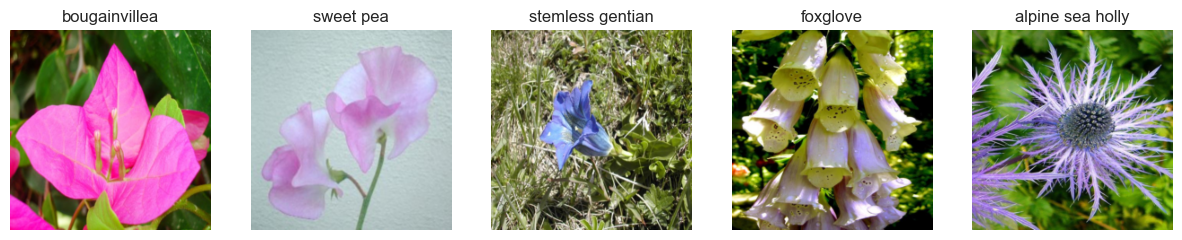

In [14]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        # Randomly select a sample from the dataset
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[sample_idx]

        # Denormalize the image
        image = image * torch.tensor([0.258,  0.209, 0.221] ).view(3, 1, 1) + torch.tensor([0.432, 0.381, 0.296]).view(3, 1, 1)
        
        # Plot the image
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f'{names[label]}')
        axes[i].axis('off')

    plt.show()

# Visualize samples from the test dataset, something for sanity really
visualize_samples(testData)

# main loop


Epoch:1, Num Batches:57, Avg Loss:4.634055, Epoch Took:29.5s, Validation:5.980% acc 4.514 loss, Training:5.882% acc 4.479 loss

Epoch:2, Num Batches:57, Avg Loss:4.492211, Epoch Took:14.2s, Validation:6.569% acc 4.378 loss, Training:6.961% acc 4.329 loss

Epoch:3, Num Batches:57, Avg Loss:4.336390, Epoch Took:14.2s, Validation:9.706% acc 4.229 loss, Training:11.667% acc 4.147 loss

Epoch:4, Num Batches:57, Avg Loss:4.191861, Epoch Took:14.7s, Validation:12.647% acc 4.068 loss, Training:14.412% acc 3.963 loss

Epoch:5, Num Batches:57, Avg Loss:4.052823, Epoch Took:14.5s, Validation:16.373% acc 3.895 loss, Training:17.059% acc 3.750 loss

Epoch:6, Num Batches:57, Avg Loss:3.885095, Epoch Took:16.0s, Validation:16.176% acc 3.898 loss, Training:19.020% acc 3.662 loss

Epoch:7, Num Batches:57, Avg Loss:3.747512, Epoch Took:15.7s, Validation:16.863% acc 3.759 loss, Training:20.882% acc 3.500 loss

Epoch:8, Num Batches:57, Avg Loss:3.584986, Epoch Took:14.2s, Validation:20.980% acc 3.525 los

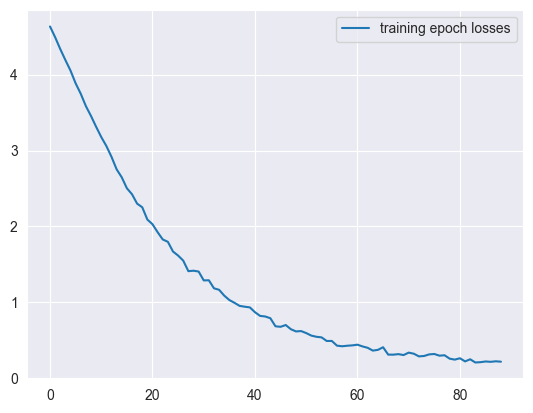

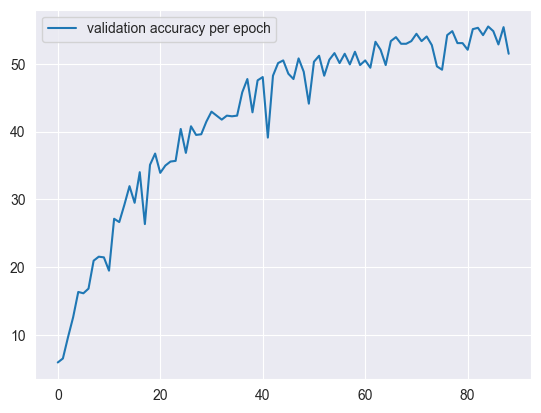

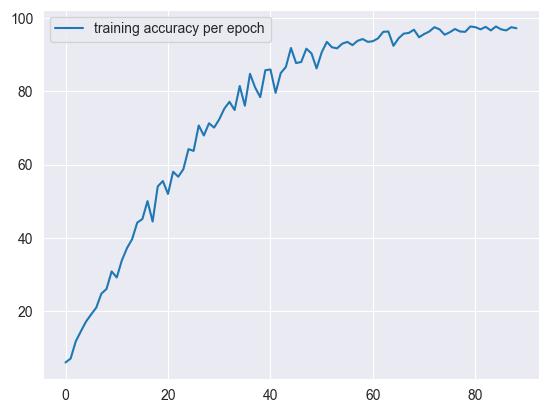

In [15]:
if __name__ == '__main__':
    BATCH_SIZE = 18
    NUM_CLASSES = 102
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 300
    
    train_dataloader = DataLoader(trainingData, batch_size=BATCH_SIZE, shuffle=True, num_workers=6, prefetch_factor=4,persistent_workers=True)
    test_dataloader = DataLoader(testData, batch_size=BATCH_SIZE, shuffle=False, num_workers=6, prefetch_factor=4,persistent_workers=True)
    val_dataloader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=False, num_workers=6,prefetch_factor=4,persistent_workers=True)

    
    
    # lrs = [0.00001,0.0001,0.001]
    # batch = [10,20,40]
    # epochs = 10
    # for lr in lrs:
    #     for bat in batch:
    #         train_dataloader = DataLoader(trainingData, batch_size=bat, shuffle=True, num_workers=4, prefetch_factor=2,persistent_workers=True)
    #         test_dataloader = DataLoader(testData, batch_size=bat, shuffle=False, num_workers=2, prefetch_factor=2,persistent_workers=True)
    #         val_dataloader = DataLoader(valData, batch_size=bat, shuffle=False, num_workers=2,prefetch_factor=4,persistent_workers=True)
    #         train(model=model,train_dataloader=train_dataloader,val_dataloader=val_dataloader,num_epochs=epochs,learning_rate=lr,device=device)
    # 
    # summary(model,input_size=(3,224,224))
    
    
    model = NeuralNet(NUM_CLASSES).to(device)
    # lrs = [0.01,0.001,0.0001]
    # for lr in lrs:
    #     model = NeuralNet(NUM_CLASSES).to(device)
    #     train(model=model,train_dataloader=train_dataloader,val_dataloader=val_dataloader,num_epochs=NUM_EPOCHS,learning_rate=lr,device=device)
    # 
    # 
    training_epoch_losses, val_acc_per, tra_acc_per = train(model=model,train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, device=device)

    plot_array(training_epoch_losses,'training epoch losses')
    plot_array(val_acc_per,'validation accuracy per epoch')
    plot_array(tra_acc_per,'training accuracy per epoch')

# runs a command that converts this notebook to a py script

In [16]:
def convert():
    !jupyter nbconvert --to script Classifier.ipynb

In [17]:
convert()

[NbConvertApp] Converting notebook Classifier.ipynb to script
[NbConvertApp] Writing 14987 bytes to Classifier.py


# todo: sanity checker for top-k

# Sanity checking

In [18]:
def plot_pred(dataset, ):
    fig, axes = plt.figure() 
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    image, label = dataset[sample_idx]
    
    
    
    
    plt.show()

In [19]:
save(model,'sgdrules')

Saved model to sgdrules.pth
